## Person re-identification using Siamese Network

<b> Why Siamese Network ?</b>

A Siamese Network is a type of neural network architecture that is used for tasks that involve finding similarities or differences between two input samples. 

The network is trained to output a high value when the two input samples are similar and a low value when they are dissimilar. This makes it useful for a variety of applications, such as image or text similarity matching, face recognition, and signature verification.

One of main advantages of a Siamese Network is that it can be trained with very few examples, making it useful for applications where data is limited. Additionally, the shared weights between the two subnetworks allow the model to generalize well to new inputs.

We will see the applications for re-identification of images in this notebook.



About Dataset 

Dataset consists of Anchor image. positive image that is closer to the anchor image, and negative image which is farther apart. So 3*400, three columns names as anchor, positive and negative. 4000 such images in the dataset.

Each of the row will pass through siamese neural net for example resnet, and will output embeddings. These are then passed to a triplet loss function, and we learn the feature representation.  The reqiuired output will be postvbe amd anchor images near to each other and negative should be far apart.

In [1]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

  Cloning https://github.com/albumentations-team/albumentations to /private/var/folders/hz/k1sk0cnn2_5fvcjlxtsp08900000gn/T/pip-req-build-g85uz7cg
  Running command git clone --filter=blob:none --quiet https://github.com/albumentations-team/albumentations /private/var/folders/hz/k1sk0cnn2_5fvcjlxtsp08900000gn/T/pip-req-build-g85uz7cg
  Resolved https://github.com/albumentations-team/albumentations to commit e3b47b3a127f92541cfeb16abbb44a6f8bf79cc8
  Preparing metadata (setup.py) ... done


<img src= "/Users/dhwaninijhawan/Documents/Portfolio/DeepLearning/siamese.png">

Import necessary libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import timm
import sys
import torch.nn.functional as F
from torch import nn
from torch.utils.data import Dataset, DataLoader

from skimage import io
from sklearn.model_selection import train_test_split

from tqdm import tqdm

sys.path.append('/content/Person-Re-Id-Dataset')

Configurations

In [3]:
data_dir = '/Users/dhwaninijhawan/Documents/Portfolio/DeepLearning/Person-Re-Id-Dataset/train/'
csv_file = '/Users/dhwaninijhawan/Documents/Portfolio/DeepLearning/Person-Re-Id-Dataset/train.csv'
batch_size = 32
learning_rate = 0.001
epochs = 15
device = torch.device('mps')
# device = 'cuda'

In [4]:
# !git clone https://github.com/parth1620/Person-Re-Id-Dataset

In [5]:
df = pd.read_csv(csv_file)
df.head()

,Anchor,Negative,Positive
0,1420_c5s3_052165_01.jpg,1334_c6s3_061492_05.jpg,1420_c3s3_051678_01.jpg
1,1420_c3s3_061978_03.jpg,0234_c3s3_079494_02.jpg,1420_c6s3_085567_02.jpg
2,1420_c5s3_062565_05.jpg,0475_c2s1_122816_08.jpg,1420_c3s3_051653_01.jpg
3,1420_c6s3_085592_04.jpg,0662_c2s2_036662_05.jpg,1420_c1s6_013446_04.jpg
4,0663_c5s3_085987_03.jpg,1463_c2s3_098102_02.jpg,0663_c3s3_085544_06.jpg


In [6]:
df.shape

(4000, 3)

Example of how a record looks like from the dataset 

In [7]:
row = df.iloc[1000]
a_img = io.imread(data_dir + row.Anchor)
p_img = io.imread(data_dir + row.Positive)
n_img = io.imread(data_dir + row.Negative)

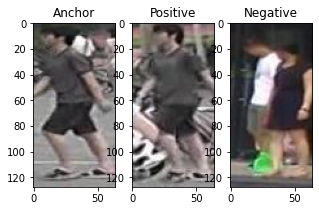

In [8]:
f, (ax1, ax2, ax3) = plt.subplots(1,3, figsize = (5,5))
ax1.set_title("Anchor")
ax1.imshow(a_img)

ax2.set_title("Positive")
ax2.imshow(p_img)

ax3.set_title("Negative")
ax3.imshow(n_img)

specify train test split dataset 


In [9]:
train_df , valid_df = train_test_split(df, test_size = 0.20, random_state = 42)

Create APN Dataset : anchor positive negative dataset, where we pass dataset as a parameter and get length, access each item of the dataset. 



In [10]:
class apn_dataset(Dataset):

  def __init__(self, df):
    self.df = df

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):
    row = self.df.iloc[idx]

    a_img = io.imread(data_dir + row.Anchor)
    p_img = io.imread(data_dir + row.Positive)
    n_img = io.imread(data_dir + row.Negative)

    # converting numpy array to torch tensor. Channel Height and width 

    a_img = torch.from_numpy(a_img).permute(2,0,1)/255.0
    p_img = torch.from_numpy(p_img).permute(2,0,1)/255.0
    n_img = torch.from_numpy(n_img).permute(2,0,1)/255.0

    return a_img,p_img,n_img

In [11]:
trainset = apn_dataset(train_df)
validset = apn_dataset(valid_df)

print(f"Size of training set is : {len(trainset)}")
print(f"Size of validation set is : {len(validset)}")

Size of training set is : 3200
Size of validation set is : 800


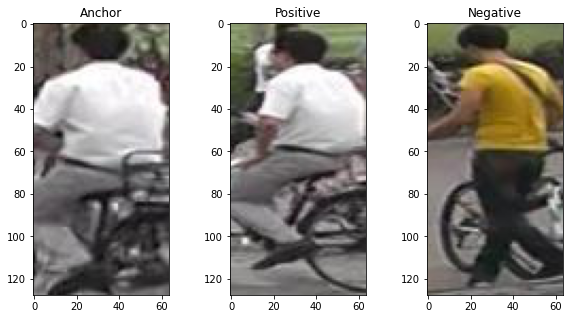

In [12]:
idx = 1000
a,p,n = trainset[idx]

f, (ax1, ax2, ax3) = plt.subplots(1,3,figsize= (10,5))

ax1.set_title('Anchor')
ax1.imshow(a.numpy().transpose((1,2,0)), cmap = 'gray')

ax2.set_title('Positive')
ax2.imshow(p.numpy().transpose((1,2,0)), cmap = 'gray')

ax3.set_title('Negative')
ax3.imshow(n.numpy().transpose((1,2,0)), cmap = 'gray')

Load dataset into batches

In [13]:
trainloader = DataLoader(trainset, batch_size= batch_size, shuffle=True)
validloader = DataLoader(validset, batch_size=batch_size)

In [14]:
print(f"No. of batches in trainloader : {len(trainloader)}")
print(f"No. of batches in validloader : {len(validloader)}")

No. of batches in trainloader : 100
No. of batches in validloader : 25


In [15]:
for a,p,n in trainloader:
  break;

print(f"One image batch shape : {a.shape}")



One image batch shape : torch.Size([32, 3, 128, 64])


32 is the munber of batch, 3 is the number of channel, height and width of the image 

Creating model using timm library.I am using the efficientnet_b0, there are various other to try out.

In [16]:
class apn_model(nn.Module):
  
  def __init__(self, emb_size = 512):

    super(apn_model, self).__init__()

    self.efficientnet = timm.create_model('efficientnet_b0', pretrained = True)
    self.efficientnet.classifier = nn.Linear(in_features= self.efficientnet.classifier.in_features, out_features=emb_size)

  def forward(self , images):
    embeddings = self.efficientnet(images)
    return embeddings

In [17]:
model = apn_model()
model.to(device);

Create train and Eval Function

In [18]:
# crterion is the loss function
def train_fn(model , dataloader, optimizer, criterion):
  model.train()
  total_loss = 0.0

  for a,p,n in tqdm(dataloader):
    a,p,n = a.to(device), p.to(device), n.to(device)

    a_embs = model(a)
    p_embs = model(p)
    n_embs = model(n)

    loss = criterion(a_embs, p_embs, n_embs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    total_loss += loss.item()

  return total_loss / len(dataloader)


In [19]:
# Validation function, similar to train except the optimizer
def eval_fn(model , dataloader,  criterion):
  model.eval()
  total_loss = 0.0

  with torch.no_grad():
    for a,p,n in tqdm(dataloader):
      a,p,n = a.to(device), p.to(device), n.to(device)

      a_embs = model(a)
      p_embs = model(p)
      n_embs = model(n)

      loss = criterion(a_embs, p_embs, n_embs)

      total_loss += loss.item()

    return total_loss / len(dataloader)

In [20]:
criterion = nn.TripletMarginLoss()
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)

Create training loop 

In [21]:
best_valid_loss = np.inf
for i in range(epochs):
  train_loss = train_fn(model, trainloader, optimizer, criterion )
  valid_loss = eval_fn(model, validloader, criterion)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    best_valid_loss = valid_loss
    print("saved_weights_success")
  
  print(f"epochs: {i + 1} train_loss : {train_loss} valid_loss: {valid_loss}")

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 25/25 [00:04<00:00,  5.59it/s]


saved_weights_success
epochs: 1 train_loss : 0.5823051461577415 valid_loss: 0.6065573883056641


100%|██████████| 25/25 [00:04<00:00,  5.77it/s]


saved_weights_success
epochs: 2 train_loss : 0.27347325906157494 valid_loss: 0.36206036746501924


100%|██████████| 25/25 [00:04<00:00,  6.01it/s]


epochs: 3 train_loss : 0.16473831057548524 valid_loss: 0.3716477286815643


100%|██████████| 25/25 [00:04<00:00,  5.33it/s]


saved_weights_success
epochs: 4 train_loss : 0.13315730445086957 valid_loss: 0.24507498860359192


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


saved_weights_success
epochs: 5 train_loss : 0.10600690841674805 valid_loss: 0.21222837924957275


100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


epochs: 6 train_loss : 0.08004001185297965 valid_loss: 0.235544615983963


100%|██████████| 25/25 [00:04<00:00,  6.15it/s]


saved_weights_success
epochs: 7 train_loss : 0.06100700601935387 valid_loss: 0.14415602535009384


100%|██████████| 25/25 [00:04<00:00,  6.12it/s]


epochs: 8 train_loss : 0.054666059538722035 valid_loss: 0.172237349152565


100%|██████████| 25/25 [00:04<00:00,  6.16it/s]


epochs: 9 train_loss : 0.04279250904917717 valid_loss: 0.14650894999504088


100%|██████████| 25/25 [00:04<00:00,  6.22it/s]


epochs: 10 train_loss : 0.03750418834388256 valid_loss: 0.19511252760887146


100%|██████████| 25/25 [00:03<00:00,  6.37it/s]


epochs: 11 train_loss : 0.04996073737740517 valid_loss: 0.15258291363716125


100%|██████████| 25/25 [00:04<00:00,  6.18it/s]


epochs: 12 train_loss : 0.04169605299830437 valid_loss: 0.18292062163352965


100%|██████████| 25/25 [00:03<00:00,  6.27it/s]


epochs: 13 train_loss : 0.04630482271313667 valid_loss: 0.2291521567106247


100%|██████████| 25/25 [00:04<00:00,  6.20it/s]


saved_weights_success
epochs: 14 train_loss : 0.0435027614235878 valid_loss: 0.12544109910726547


100%|██████████| 25/25 [00:04<00:00,  6.25it/s]

epochs: 15 train_loss : 0.02753426820039749 valid_loss: 0.1960369688272476


Get anchor embeddings

In [22]:
def get_encoding_csv(model, anc_img_names):
  anc_img_names_arr = np.array(anc_img_names)
  encodings = []

  model.eval()
  with torch.no_grad():
    for i in tqdm(anc_img_names_arr):
      a = io.imread(data_dir + i)
      a = torch.from_numpy(a).permute(2,0,1)/255.0
      a = a.to(device)
      a_enc = model(a.unsqueeze(0))
      encodings.append(a_enc.squeeze().cpu().detach().numpy())

    encodings = np.array(encodings)
    encodings = pd.DataFrame(encodings)
    df_enc = pd.concat([anc_img_names, encodings], axis = 1)
  return df_enc

In [23]:
model.load_state_dict(torch.load('best_model.pt'))
df_enc = get_encoding_csv(model, df['Anchor'])

100%|██████████| 4000/4000 [18:21<00:00,  3.63it/s]   


Inference

In [24]:
df_enc.to_csv('database.csv', index = False)
df_enc.head()

,Anchor,0,1,2,3,4,5,6,7,8,...,502,503,504,505,506,507,508,509,510,511
0,1420_c5s3_052165_01.jpg,-0.099832,-0.655168,0.511927,0.821587,-0.063731,0.756556,-0.093147,-0.227635,1.336343,...,0.154635,1.198058,-0.105895,0.003160,-0.604135,0.544586,0.736712,-0.002311,-0.153805,-0.159411
1,1420_c3s3_061978_03.jpg,0.013626,-0.840258,0.213392,0.727903,0.077429,0.980124,-0.137586,-0.208286,1.504284,...,0.265483,1.040832,-0.061938,-0.279331,-0.514056,0.721277,0.567192,-0.059673,-0.390726,-0.179684
2,1420_c5s3_062565_05.jpg,-0.026903,-0.683330,0.484658,0.946198,-0.050185,0.819584,-0.094113,-0.178181,1.470973,...,0.230307,1.240760,0.097632,-0.005319,-0.640789,0.626998,0.894057,0.212017,-0.224204,-0.064335
3,1420_c6s3_085592_04.jpg,-0.256907,-0.323377,0.612542,1.071326,0.109068,0.502107,0.097096,-0.212998,1.428635,...,-0.088217,1.571648,0.022967,0.166333,-0.587711,0.449105,0.760649,0.177228,0.054423,-0.018626
4,0663_c5s3_085987_03.jpg,0.580611,-0.830817,0.710441,-0.267175,-0.649111,-0.435502,-0.230249,0.084464,-1.197368,...,-0.057133,-0.706589,-0.757212,0.695581,0.251562,-0.557403,0.272082,-0.515483,0.280907,-0.583039


In [25]:
def euclidean_dist(img_enc, anc_enc_arr):
  dist = np.sqrt(np.dot(img_enc - anc_enc_arr, (img_enc - anc_enc_arr).T))
  return dist

In [26]:
idx = 0
img_name = df_enc['Anchor'].iloc[idx]
img_path = data_dir + img_name

img = io.imread(img_path)
img = torch.from_numpy(img).permute(2, 0, 1)/255

model.eval()
with torch.no_grad():
  img = img.to(device)
  img_enc = model(img.unsqueeze(0))
  img_enc = img_enc.detach().cpu().numpy()

In [27]:
anc_enc_arr = df_enc.iloc[:,1:].to_numpy()
anc_img_names = df_enc['Anchor']

In [28]:
distance = []
for i in range(anc_enc_arr.shape[0]):
  dist = euclidean_dist(img_enc, anc_enc_arr[i: i+1, :])
  distance = np.append(distance, dist)

In [29]:
closest_idx = np.argsort(distance)

In [30]:
 #%pip install utils

In [31]:
def plot_image(image, factor=1.0, clip_range=None, **kwargs):
    """
    Utility function for plotting RGB images.
    """
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
    if clip_range is not None:
        ax.imshow(np.clip(image * factor, *clip_range), **kwargs)
    else:
        ax.imshow(image * factor, **kwargs)
    ax.set_xticks([])
    ax.set_yticks([])

In [32]:
%pip install utils.py

Note: you may need to restart the kernel to use updated packages.


In [33]:
from utils import plot_closest_imgs


plot_closest_imgs(anc_img_names, data_dir, img, img_path, closest_idx, distance, no_of_closest = 4);

ImportError: cannot import name 'plot_closest_imgs' from 'utils' (/Users/dhwaninijhawan/opt/anaconda3/lib/python3.9/site-packages/utils/__init__.py)